In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import codecs
import array
import sys
import os

def load_tdms(path, ch_num):
    ch = [[] for _ in range(ch_num)]
    with codecs.open(path, 'rb') as f:
        while True:
            tdms = f.read(28) 

            if tdms==b'': 
                break

            seg_ofs = tdms[12:20]
            by1 = array.array('l')
            by1.frombytes( seg_ofs )
            seg_ofs = np.asarray(by1)[0]
            data_ofs= tdms[20:28] 
            by2 = array.array('l')
            by2.frombytes( data_ofs )
            data_ofs = np.asarray(by2)[0]
            tdms = f.read(data_ofs)

            tdms = f.read(seg_ofs-data_ofs)
            by = array.array('f')
            by.frombytes( tdms )
            data = np.asarray( by )

            for i in range(ch_num):
                ch[i].append( data[i::ch_num].reshape(-1,1) )

    for i in range(ch_num):
        ch[i] = np.vstack(ch[i])[:,0]

    return ch

In [4]:
def data_split(t, x, split_t_r, overlap):

    split_data = []
    one_frame_N = int(len(t)*split_t_r)  # 1フレームのサンプル数
    overlap_N = int(one_frame_N*overlap)  # オーバーラップするサンプル数
    start_S = 0
    end_S = start_S + one_frame_N

    while True:
        t_cont = t[start_S:end_S]
        x_cont = x[start_S:end_S]
        split_data.append([t_cont, x_cont])

        start_S = start_S + (one_frame_N - overlap_N)
        end_S = start_S + one_frame_N

        if end_S > len(t):
            break

    return np.array(split_data)

In [2]:
def FFT_main(t, x, dt, split_t_r, overlap, window_F, output_FN, y_label, y_unit):

    # データをオーバーラップして分割する。
    split_data = data_split(t, x, split_t_r, overlap)

    # FFTを行う。
    FFT_result_list = []
    for split_data_cont in split_data:
        FFT_result_cont = FFT(split_data_cont, dt, window_F)
        FFT_result_list.append(FFT_result_cont)

    # 平均化
    fq_ave = FFT_result_list[0][0]
    F_abs_amp_ave = np.zeros(len(fq_ave))
    for i in range(len(FFT_result_list)):
        F_abs_amp_ave = F_abs_amp_ave + FFT_result_list[i][1]
    F_abs_amp_ave = F_abs_amp_ave/(i+1)

    plot_FFT(t, x, fq_ave, F_abs_amp_ave, output_FN, "ave", 1, y_label, y_unit)

    return fq_ave, F_abs_amp_ave

In [3]:
def FFT(data_input, dt, window_F):

    N = len(data_input[0])

    # 窓の用意
    if window_F == "hanning":
        window = np.hanning(N)          # ハニング窓
    elif window_F == "hamming":
        window = np.hamming(N)          # ハミング窓
    elif window_F == "blackman":
        window = np.blackman(N)         # ブラックマン窓
    else:
        print("Error: input window function name is not sapported. Your input: ", window_F)
        print("Hanning window function is used.")
        hanning = np.hanning(N)          # ハニング窓

    # 窓関数後の信号
    x_windowed = data_input[1]*window

    # FFT計算
    F = np.fft.fft(x_windowed)
    F_abs = np.abs(F)
    F_abs_amp = F_abs / N * 2
    fq = np.linspace(0, 1.0/dt, N)
#     fq = np.linspace(0, N*dt, N)


    # 窓補正
    acf = 1/(sum(window)/N)
    F_abs_amp = acf*F_abs_amp

    # ナイキスト定数まで抽出
    fq_out = fq[:int(N/2)+1]
    F_abs_amp_out = F_abs_amp[:int(N/2)+1]

    return [fq_out, F_abs_amp_out]

In [6]:
def plot_FFT(t, x, fq, F_abs_amp, output_FN, IDN, final_graph, y_label, y_unit):

    fig = plt.figure()
    ax = fig.add_subplot(111)

    plt.xlabel('freqency(kHz)', fontsize=16)
    plt.ylabel(y_label+"[dB]", fontsize=16)

    ax.set_xlim(0,500000)
    ax.set_xticklabels([ 0 ,100, 200, 300, 400, 500])
    
    plt.plot(fq, 20 * np.log10(F_abs_amp))
    
    p = plt.tick_params(labelsize=16)
    plt.tight_layout()

    if final_graph == 0:
        plt.savefig(output_FN[:-4]+"_"+str(IDN) +
                    "_FFTtemp"+output_FN[-4:], dpi=300)
    elif final_graph == 1:
        plt.savefig(output_FN, dpi=300)

    return 0

[8.09294962e-05 8.08759505e-05 8.07182718e-05 ... 8.04651310e-05
 8.07182718e-05 8.08759505e-05]
[0.02388436 0.02181957]


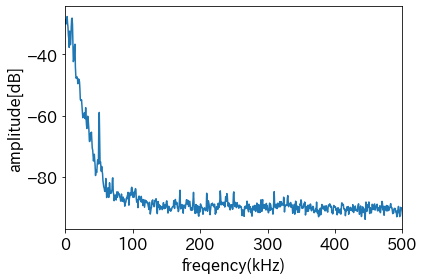

In [12]:
path = r'C:\Users\pmg07\Desktop\2021_1115_切削実験\ae\AE_368.tdms'
d = load_tdms(path, ch_num=3)
dt = 1/10**6
last_t = 0
y = d[0][5000000:5016385]

# y = d[0][:]
N = len(y)
f = y
fq = np.linspace(0, N*dt, N)

# fft_data = np.abs(np.fft.rfft(y))
# freqList = np.fft.rfftfreq(len(s), 1.0 / rate)  # 横軸
# plt.loglog(freqList, 10 * np.log(fft_data))
# plt.xlabel('Frequency')
# plt.ylabel('Power')
# plt.show()

output_FN = "./AE_FFT/AE_FFT_368.png"
split_t_r = 0.1
overlap = 0.5
window_F = "hanning" 
y_label = "amplitude"
y_unit = "V"

fft_r = FFT_main(fq, f, dt, split_t_r, overlap, window_F, output_FN, y_label, y_unit)
print(np.fft.irfft(fft_r[1],len(y)))
print(fft_r[1][10:12])